In [1]:
from attention import AttentionLayer
import pandas as pd
import numpy as np
import scipy as sp
import re
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, Bidirectional, Input, Embedding, Dropout
from tensorflow.keras.models import Model
import os
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import nltk.stem

<h2> Data Preprocessing </h2>

In [2]:
indices = collections.deque()
for path, dirs, files in os.walk("data"):
    if len(dirs)==0:
        stem = path.split("/")[-1]+"/"
        for file in files:
            indices.append(stem+file)
newsdf = pd.DataFrame(index=np.unique(indices), columns=["Text", "Summary", "Category"])

In [3]:
newsdf.Category = np.vectorize(lambda s: s.split("/")[0])(newsdf.index.values)
for path, dirs, files in os.walk("data"):
    if len(dirs)==0:
        stem = path.split("/")[-1]+"/"
        col = "Text" if "articles" in path else "Summary"
        for file in files:
            newsdf.loc[stem+file, col] = open(path+"/"+file, "rb").read()

In [4]:
def bytedecoder(string):
    try:
        string = string.decode('utf-8')
        return string
    except:
        return np.nan
for col in ['Text', 'Summary']:
    newsdf[col] = newsdf[col].apply(bytedecoder)
newsdf.dropna(how="any", inplace=True)
newsdf.drop_duplicates(inplace=True)

In [5]:
def cleaner(s):
    s = re.sub("\n"," ", re.sub("[,<>@#\'\")(]","", s))
    s = re.sub("\."," \. ",re.sub("\?", " \? ",re.sub("-"," - ", s)))
    #NLTK Stemming to Reduce Domain Vocabulary Size
    s = " ".join(np.vectorize(lambda s: s if len(s)<=3 else nltk.stem.WordNetLemmatizer().lemmatize(s))
                 (np.array(s.split())))
    return BeautifulSoup(s, "lxml").text.lower()
for col in ['Text', 'Summary']:
    newsdf[col] = newsdf[col].apply(cleaner)
newsdf['Summary'] = "_START "+newsdf['Summary']

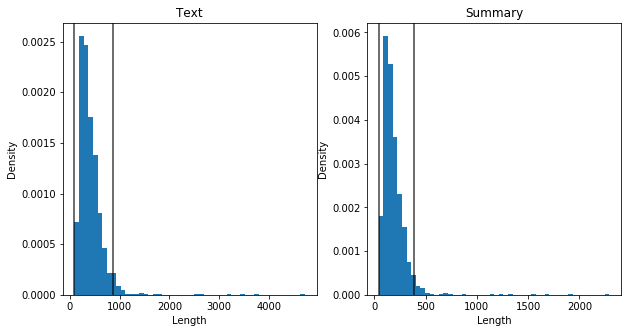

In [6]:
plt.figure(figsize=(10,5))
for col, plot in [('Text', 1), ('Summary', 2)]:
    plt.subplot(1,2,plot)
    lengths = newsdf[col].apply(lambda s: len(s.split()))
    plt.hist(lengths, bins=50, density=True)
    quants = lengths.quantile([0.25,0.75])
    plt.axvline(np.maximum(np.min(lengths), quants[0.25]-1.5*quants.diff().values[-1]), color="black", alpha=0.75)
    plt.axvline(quants[0.75]+1.5*quants.diff().values[-1], color="black", alpha=0.75)
    plt.xlabel("Length")
    plt.ylabel("Density")
    plt.title(col)

In [7]:
#Set maximum lengths at 1000 for text and 500 for summary, and remove any exceeding entries
MAX_TEXT_LEN = 800
MAX_SUMMARY_LEN = 400
newsdf.drop(newsdf[(newsdf['Text'].apply(lambda s: len(s.split()))>MAX_TEXT_LEN)|(newsdf['Summary'].apply(
    lambda s: len(s.split()))>MAX_SUMMARY_LEN)].index, inplace=True)

In [8]:
def padtokens(series):
    token = tf.keras.preprocessing.text.Tokenizer()
    token.fit_on_texts(series)
    words = token.texts_to_sequences(series)
    words = tf.keras.preprocessing.sequence.pad_sequences(words, maxlen=MAX_TEXT_LEN, padding="post")
    return words, token
texts, texttoken = padtokens(newsdf['Text'])
summs, summtoken = padtokens(newsdf['Summary'])

In [9]:
np.random.seed(1)
testindices = np.random.choice(np.arange(texts.shape[0]), np.int(0.2*texts.shape[0]), replace=False)
trainindices = np.unique(list(set(np.arange(texts.shape[0]))-set(testindices)))
trainX, testX = texts[trainindices], texts[testindices]
trainY, testY = summs[trainindices], summs[testindices]
trainX.shape, trainY.shape, testX.shape, testY.shape

((1622, 800), (1622, 800), (405, 800), (405, 800))

<h2> Model Design </h2>

In [10]:
lstmdim = 500
tf.keras.backend.clear_session()
#Encoding Segment
textinput = Input(shape=(MAX_TEXT_LEN,))
textembed = Embedding(len(texttoken.word_index)+1, lstmdim, trainable=True, mask_zero=True)(textinput)
encout1, _, _, _, _ = Bidirectional(LSTM(lstmdim, return_sequences=True, return_state=True))(textembed)
encout1 = Dropout(0.1)(encout1)
_, enc_h, enc_c = LSTM(lstmdim, return_sequences=True, return_state=True)(encout1)
#Decoding Segment
summinput = Input(shape=(None,))
decembed_layer = Embedding(len(summtoken.word_index)+1, lstmdim, trainable=True)
summembed = decembed_layer(summinput)
declstm_layer = LSTM(lstmdim, return_sequences=True, return_state=True)
decout, _, _ = declstm_layer(summembed, initial_state=[enc_h, enc_c])
decdense_layer = Dense(len(summtoken.word_index)+1, activation="softmax")
preds = decdense_layer(decout)
mdl = Model(inputs=[textinput, summinput], outputs=preds)
mdl.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
mdl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 800, 500)     13643000    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 800, 1000),  4004000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
check = tf.keras.callbacks.ModelCheckpoint("newsbbcseq2seq.h5", save_best_only=True, monitor="val_loss", verbose=True)
hist = mdl.fit([trainX, trainY[:,:-1]], trainY.reshape(trainY.shape[0], trainY.shape[1], 1)[:,1:], epochs=10, callbacks=[check],
               batch_size=16, verbose=True,
               validation_data=([testX, testY[:,:-1]], testY.reshape(testY.shape[0], testY.shape[1], 1)[:,1:]))

Train on 1682 samples, validate on 420 samples
Epoch 1/20


In [ ]:
#Run-Time Model Graphs
encode_model = Model(inputs=textinput, outputs=[enc_h, enc_c])
dec_h = Input(shape=(lstmdim,))
dec_c = Input(shape=(lstmdim,))
decinput = Input(shape=(None,))
decembed = decembed_layer(decinput)
output, new_h, new_c = declstm_layer(decembed, initial_state=[dec_h, dec_c])
output = decdense_layer(output)
decode_model = Model(inputs=[decinput, dec_h, dec_c], outputs=[output, new_h, new_c])